<font size=4 color=#376cb0 face=华文中宋 weight=50 line-heiht=100px>&emsp;&ensp;此脚本可以实现 ——
1. 对MySQL数据进行读取和下载，并对原始数据做出转换，所用转换系数读取自excel表而非数据库中错误的转换系数
2. 生成SQL命令行，以查询数据库中每个表格（对应各采集设备）的行数和首尾时间戳，以此确定数据可用性
3. 绘制采集设备可用性的时间视图，移动光标可查看不同设备每天的数据概况，以方便制定进一步修复策略
4. 绘制某单测点可用性的时间视图，以方便选择测点时间段
5. 对缺失和过饱和问题不严重的数据，制作处理方案表单
6. 给出设备型号列表和所需数据时间段的首尾，即可从MySQL数据库中批量导出数据，默认进行数据插补或删减修复，并转存成内存占用更少的pkl格式，亲测可节约80%的存储空间，同时，下载时会自动绕开已下载部分
7. 给出设备型号和所需数据时间段的首尾，即可一键绘制时间序列图：会根据处理方案表单自动查询数据不存在和数据不可用的问题，并及时反馈说明无法绘图的原因；对于数据可用但未下载到本地的情况，会有提示下载的交互操作，确认后会自动执行下载-修复-转存等一系列操作（下载时会自动绕开已下载部分），然后自动执行绘图
8. 在绘图处提供了临时修改具体绘图设置的cell，方便及时改动
    
    补充说明：
   1. 运行Prepare后，其他模块都可以单独运行
   2. 若没有数据库，但是Others文件夹下的文件齐全，那么在运行Prepare时，会提示OperationalError，此时对于数据批量导出模块和数据展示模块会有影响，因为会涉及到下载数据，但如果在root_dir这个目录下有pkl格式的数据文件，那么就不会触发下载，也就不会影响数据展示模块
    
</font>

# Prepare

In [6]:
from SHZX_Data_export_and_input import *

# 了解数据概况

## 生成查询表格行数的SQL命令

In [ ]:
# 生成table_list
sql = '''SELECT table_name INTO outfile '%s' fields terminated by '\t'
FROM information_schema.TABLES WHERE table_schema = 'aiot' '''%table_list_path
if not os.path.exists(table_list_path):
    cur.execute(sql)

# 生成查询表格行数的SQL命令
with open(table_list_path, 'r') as f:
    table_list = pd.read_csv(f, header=None)
table_list = [x for x in table_list[0] if 'temperture' in x or 'exp' in x and 'exp_instrument_info' not in x or 'vibration' in x or 'crack' in x and 'crack_instrument_info' not in x]
table_list = ["SELECT '%s' table_name, COUNT(*) rows, MIN(cur_time) head, MAX(cur_time) tail FROM %s UNION"%(x,x) for x in table_list]
sql = '\n'.join(table_list)
sql = sql[:-5] + "\nINTO outfile '%s' fields terminated by '\t'"%table_rows_path
with open(sql_command_for_rows_path, 'w') as f: # 将查询到的表格行数存成一份txt
    f.writelines(sql)
# cur.execute(sql)

## 绘制设备可用性视图

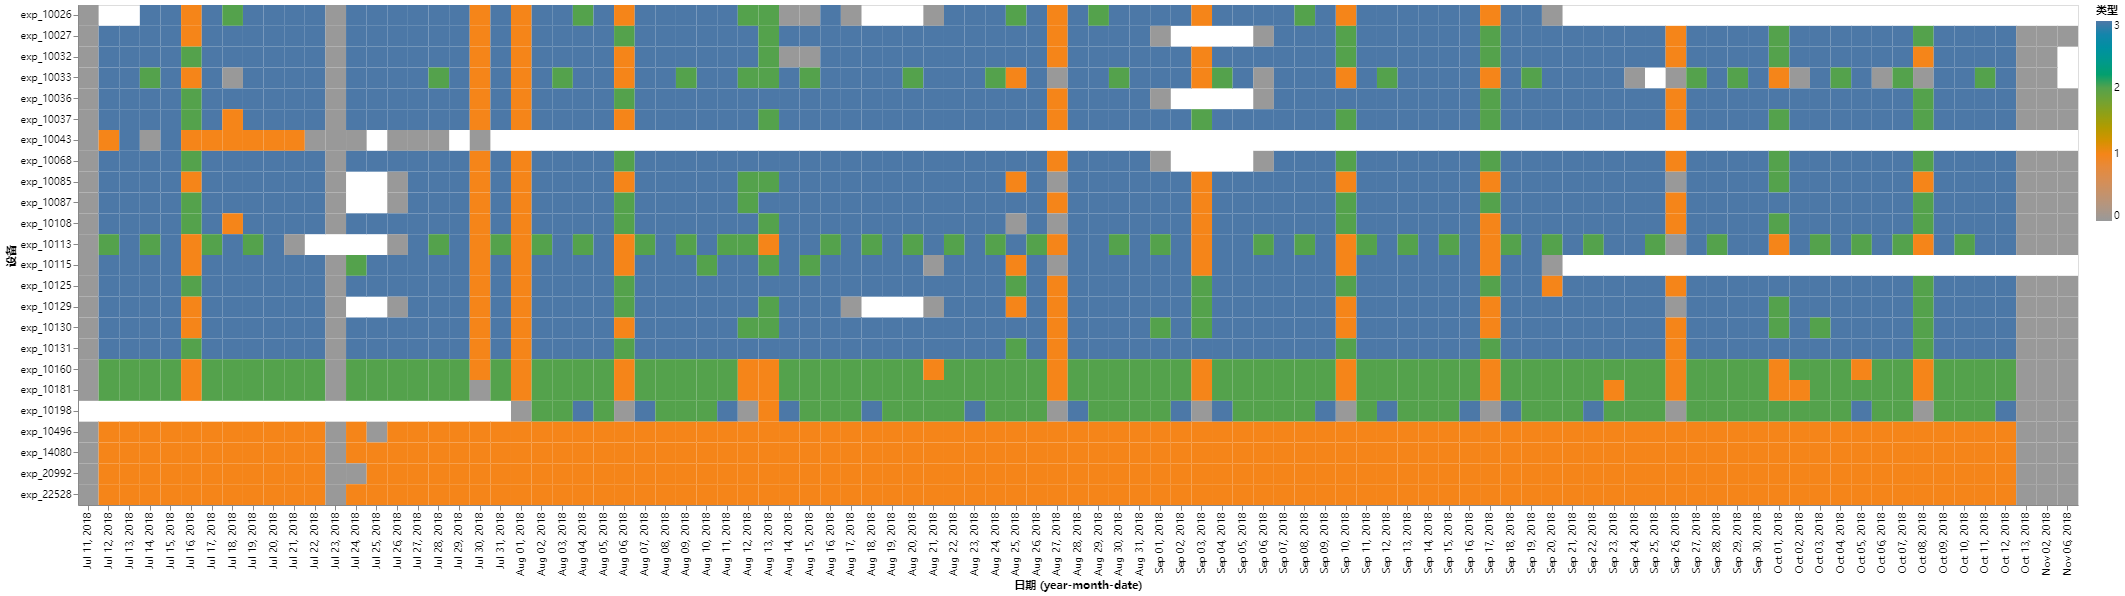

In [5]:
equipment_availability()

## 绘制测点可用性视图

In [ ]:
i_code = 'ZD-117-01'
which_dates_are_good(i_code)

## 对缺失数据或过饱和数据制作处理方案表单

In [ ]:
exp_info0 = exp_info[exp_info['类型']==0] # 小于8640000*(1-1/100)
exp_info1 = exp_info[exp_info['类型']==1] # 小于8640000
exp_info2 = exp_info[exp_info['类型']==2] # 等于8640000
exp_info3 = exp_info[exp_info['类型']==3] # 大于8640000
exp_info0['插入或删除'] = ''; exp_info2['插入或删除'] = '';
exp_info1['插入或删除'] = exp_info1['行数'].apply(lambda x: np.linspace(2, x, 8640000-x, endpoint=False, dtype=int)+range(1,8640001-x))
exp_info3['插入或删除'] = exp_info3['行数'].apply(lambda x: np.linspace(2, x, x-8640000, endpoint=False, dtype=int)-range(1,x-8639999))
data_repair_info = pd.concat([exp_info0,exp_info1,exp_info2,exp_info3], ignore_index=True)
data_repair_info['编号'] = data_repair_info.apply(lambda x:x['设备']+'-'+x['日期'].strftime('%Y-%m-%d').replace('-','_'), axis=1)
data_repair_info = data_repair_info[['编号', '类型', '插入或删除']]
with open(data_repair_info_path, 'wb') as f:
    pkl.dump(data_repair_info, f)

# 数据批量导出

In [ ]:
# 数据展示可以对单测点进行导出，此处是为了方便批量导出
date_start = '2018-07-11'; date_end = '2018-07-11'
code_list = ['ZD-117-01','ZD-117-02','ZD-117-03','ZD-117-04',
             'ZD-124-01','ZD-124-02','ZD-124-03','ZD-124-04',
             'ZD-125-01','ZD-125-02','ZD-125-03','ZD-125-04',
             'FS-132-01','FS-132-02'
              ]
date_list = get_date_list(date_start, date_end)
data_export(code_list, date_list)

# 数据展示

## 绘图设置

In [14]:
## 绘图设置 
def alt_configure(chart):
    chart = (chart
             .properties(width=1100, height=200)
             .configure_title(font='Times New Roman', fontSize=18, fontWeight='bold')
             .configure_axis(titleFontSize=16, labelFontSize=12, labelFont='Times New Roman', titleFont='Times New Roman')
             .configure_legend(title=None, labelFont='Times New Roman',labelFontSize=15, labelFontWeight='bold',
                               orient='top-left', symbolStrokeWidth=4, symbolSize=300,
                               rowPadding=15, labelLimit=400, symbolOffset=15)
             .interactive(bind_x = False) # 交互性设置
            )
    return(chart)

## FS
def draw_FS1(data, title): # 风速
    F1_chart = (alt
                .Chart(data['wind_speed'].reset_index(), title=title)
                .mark_line(strokeWidth=2, strokeOpacity=0.9)
                .encode(#alt.X('index:T', title=None, axis=alt.Axis(format='%d-%0H:%0M')),
                        alt.X('index:T', title=None, axis=alt.Axis(format='%m-%0d')),
                        alt.Y('wind_speed:Q', title='Wind Speed (m/s)'))
                )
    alt_configure(F1_chart).display()
    
def draw_FS2(data, title): # 风向
    F2_chart = (alt
                .Chart(data['wind_direction'].reset_index(), title=title)
                .mark_line(strokeWidth=2, strokeOpacity=0.9)
                .encode(#alt.X('index:T', title=None, axis=alt.Axis(format='%d-%0H:%0M')),
                        alt.X('index:T', title=None, axis=alt.Axis(format='%m-%0d')),
                        alt.Y('wind_direction:Q', title='Wind Direction (°)'))
                )
    alt_configure(F2_chart).display()

## ZD

In [ ]:
# i_code_list = ['ZD-124-01','ZD-124-02','ZD-124-03','ZD-124-04',
#                'ZD-117-01','ZD-117-02','ZD-117-03','ZD-117-04']
i_code_list = ['ZD-124-01']
date_start = '2018-8-16'
date_end = '2018-8-17'
resample_frequency = '1T'
for i_code in i_code_list:
    # which_dates_are_good(i_code) # 查看该测点的哪些时间段可用
    data = get_data_3M(i_code, date_start, date_end, resample_frequency)
    draw_3M(data, i_code)

## FS

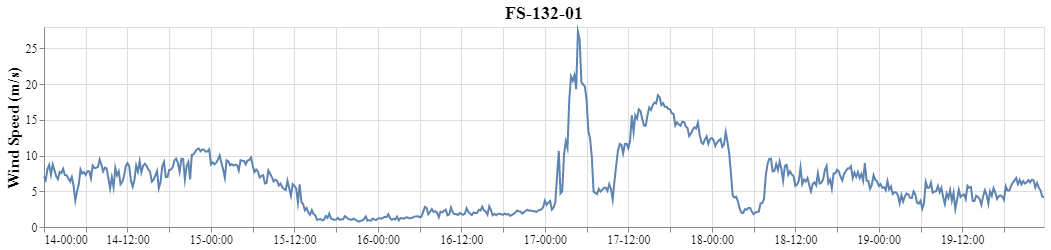

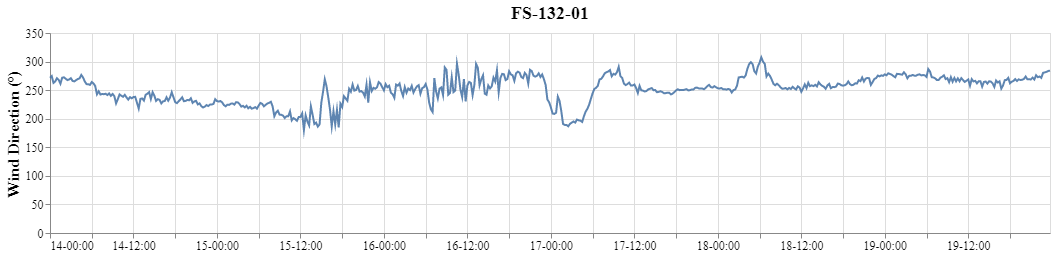

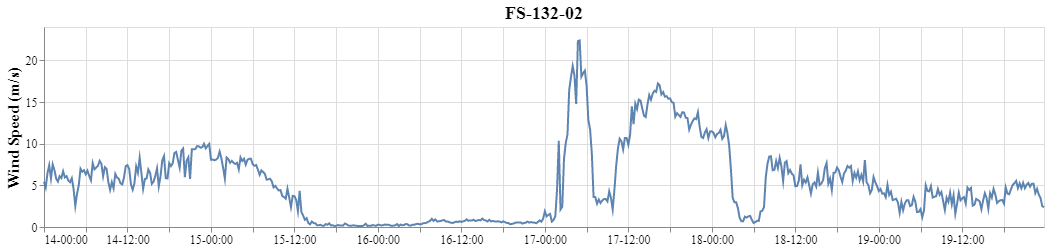

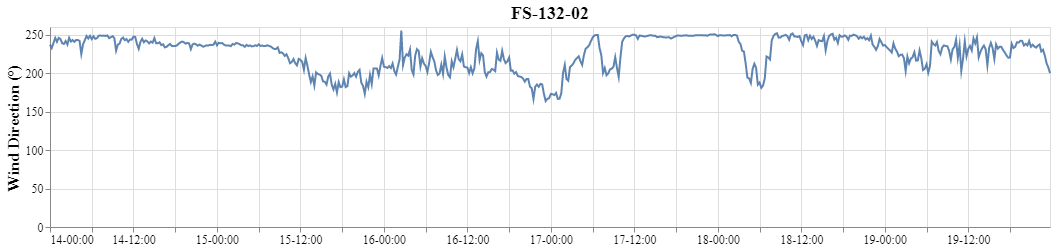

In [13]:
i_code_list = ['FS-132-01', 'FS-132-02']
date_start = '2018-8-14'
date_end = '2018-8-19'
resample_frequency = '15T'
for i_code in i_code_list:
    # which_dates_are_good(i_code) # 查看该测点的哪些时间段可用
    data = get_data_mean(i_code, date_start, date_end, resample_frequency)
    draw_FS1(data, i_code)
    draw_FS2(data, i_code)
#     draw_FS3(data, i_code)
#     draw_FS4(data, i_code)

对于FS-132-02，以下日期的数据不存在，将以0代替
['2018-09-25']
对于FS-132-02，以下日期的数据修复策略待定，将以0代替
['2018-07-11', '2018-07-18', '2018-07-23', '2018-08-27', '2018-09-06', '2018-09-24', '2018-09-26', '2018-10-02', '2018-10-06', '2018-10-08']


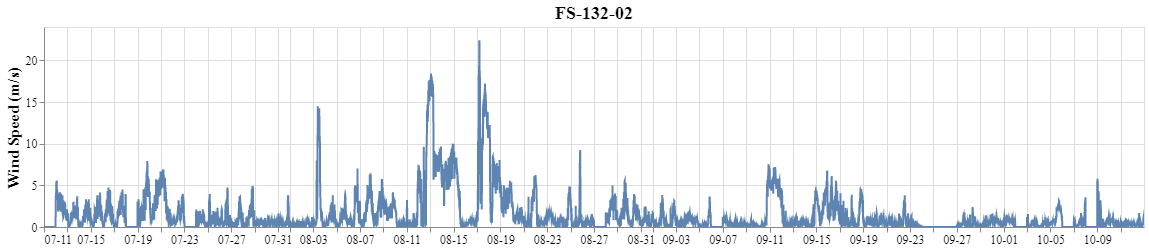

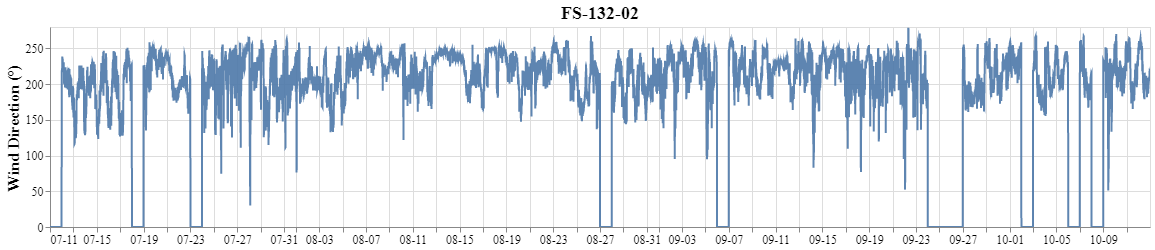

In [19]:
i_code_list = ['FS-132-02']
date_start = '2018-7-11'
date_end = '2018-10-12'
resample_frequency = '15T'
for i_code in i_code_list:
    # which_dates_are_good(i_code) # 查看该测点的哪些时间段可用
    data = get_data_mean(i_code, date_start, date_end, resample_frequency)
    draw_FS1(data, i_code)
    draw_FS2(data, i_code)
#     draw_FS3(data, i_code)
#     draw_FS4(data, i_code)

In [18]:
#Fs1
mean = data[data['wind_direction']!=0].mean()
std = data[data['wind_direction']!=0].std()
print(mean,'\n',mean-std,'\n',mean+std)

wind_speed          2.601479
wind_direction    256.932398
dtype: float64 
 wind_speed         -0.108034
wind_direction    223.520336
dtype: float64 
 wind_speed          5.310992
wind_direction    290.344461
dtype: float64


In [12]:
#Fs2
mean = data[data['wind_direction']!=0].mean()
std = data[data['wind_direction']!=0].std()
print(mean,'\n',mean-std,'\n',mean+std)

wind_speed          1.650928
wind_direction    213.859204
dtype: float64 
 wind_speed         -0.862451
wind_direction    185.334148
dtype: float64 
 wind_speed          4.164308
wind_direction    242.384259
dtype: float64


## WRF计算

In [ ]:
file = r'E:\【论文】\【大论文】\上海中心\其他\ShanghaiCenterBuilding_[(121.5011467,31.23551512), 1, 632].csv'
data = pd.read_csv(file, skiprows=9)[['#TimeInfo','speed','direction']]
data.columns = ['time','wind_speed', 'wind_direction']
data.index = pd.DatetimeIndex(data['time'].str.replace('_','-').values)+pd.Timedelta('8H')
date_start = '2018-08-16'; date_end = '2018-08-17'

draw_FS1(data[date_start: date_end], 'WRF计算')
draw_FS2(data[date_start: date_end], 'WRF计算')
draw_FS3(data[date_start: date_end], 'WRF计算')
draw_FS4(data[date_start: date_end], 'WRF计算')

## HB WRF

In [ ]:
file = r'E:\【论文】\【小论文】\航博\航博数据\WRF\Hangbo2011_[(121.91567821,30.8982838), 1, 35].csv'
data = pd.read_csv(file, skiprows=9)[['#TimeInfo','speed','direction']]
data.columns = ['time','wind_speed', 'wind_direction']
data.index = pd.DatetimeIndex(data['time'].str.replace('_','-').values)+pd.Timedelta('8H')
date_start = '2011.8.6 13:00'; date_end = '2011.8.7 05:00'
        
draw_FS1(data[date_start: date_end], 'WRF计算')
draw_FS2(data[date_start: date_end], 'WRF计算')
draw_FS3(data[date_start: date_end], 'WRF计算')
draw_FS4(data[date_start: date_end], 'WRF计算')

In [ ]:
a=5